In [153]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# SK-learn libraries for data processing.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier    
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [154]:
# Load data using pandas.
train_data = pd.read_csv('data/train_users_2.csv')
test_data = pd.read_csv('data/test_users.csv')
print "Train data shape: {0}".format(train_data.shape)
print "--------------Train Data----------------------"
print train_data.info()
print "----------------------------------------------"

print "\n"
print "Test data shape: {0}".format(test_data.shape)
print "---------------Test Data----------------------"
print test_data.info()
print "----------------------------------------------"

Train data shape: (213451, 16)
--------------Train Data----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float

In [155]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add age to features.
    # Set NA values to -1.
    data["age"] = data["age"].fillna(-1)
    # Add age data to training data.
    features_data = np.column_stack((features_data, np.array(data["age"])))
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(train_data)
test_data_x = ExtractFeatures(test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


### Exploring the data

#### Analysis of class distribution

Check training data to see how classes are distributed. It is obvious the training data is heavily imbalanced. 

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64


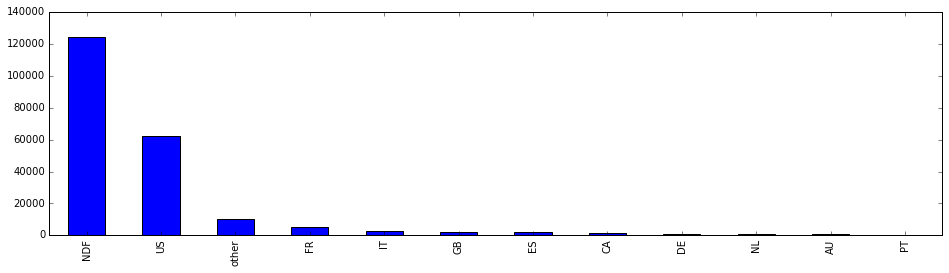

In [156]:
plt.figure(figsize=(16,4))
country_dist = train_data["country_destination"].value_counts()
plt.subplot(1,1,1)
country_dist.plot.bar()

print country_dist*1.0 / sum(country_dist)

#### Analysis of age data
We'll start with the assumption that valid age ranges should be between 18-100 since the minimum age according to the Terms of Service is 18. Any values outside of this range should be cleaned into valid values or set to 0
as invalid.

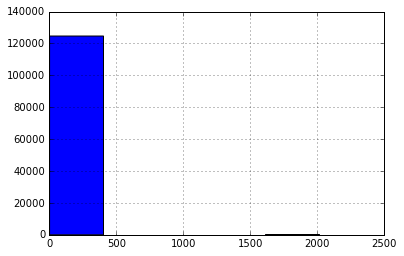

In [157]:
# Get all age values that are greater than zero.
GTE_zero_age = train_data[train_data.age >= 0].age
# Plot a histogram of these values.
GTE_zero_age.hist(bins=5)

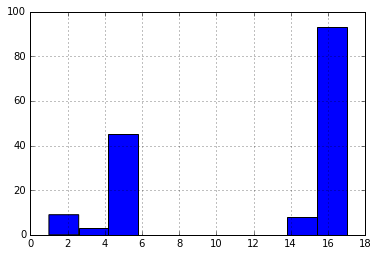

In [158]:
# Get all age values that are between 0 and 18.
under_18 = GTE_zero_age[GTE_zero_age < 18]
under_18.hist()
# All these values should be treated as invalid values.

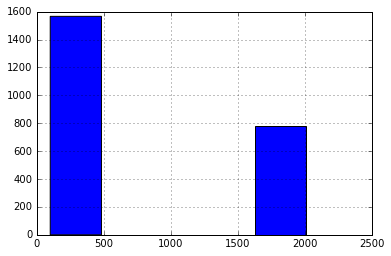

In [159]:
# From this, we can see that there are many large values.
# Assuming anything above 100 is not a valid, let's plot the
# histogram of those values.
GT_150 = train_data[train_data.age > 100].age
GT_150.hist(bins=5)
# We can't make much sense out of values between 100-1915 so
# those should be treated as invalid values as well.

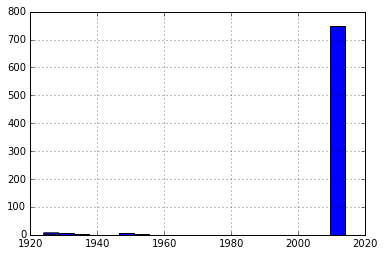

In [160]:
# Let's look more closely at those values greater than 1915.
GT_1915 = train_data[train_data.age > 1915].age
GT_1915.hist(bins=20)
# We have some values between 1915 and 1997 which we can
# assume could be birth years.
# The large number of values > 1997 are likely the current
# year the user registered.

In [161]:
# Helper function to clean up the age data based off
# this analysis in both the training and test data.
def CleanAgeData(df):
    age_data = df.age
    # Set missing values to -1.
    age_data = age_data.fillna(-1)
    # Set invalid values to 0.
    # Values between 0-18 are considered invalid.
    age_data[age_data.isin(range(0,18))] = 0
    # Values between 100-1915 are considered invalid.
    age_data[age_data.isin(range(101,1915))] = 0
    # Values >2010 are considered invalid.
    age_data[age_data > 1997] = 0
    # Compute age for values between 1915-1997.
    age_data[age_data.isin(range(1915,1998))] = 2015 - age_data[age_data.isin(range(1915,1998))]
    return age_data

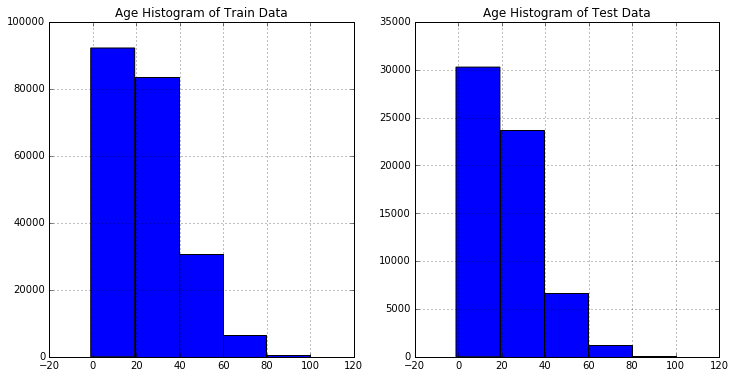

In [162]:
# Clean up training and test age data and plot cleaned data.
plt.figure(figsize=(12, 6))
train_age_data = CleanAgeData(train_data)
plt.subplot(1, 2, 1)
train_age_data.hist(bins=5)
plt.title("Age Histogram of Train Data")

test_age_data = CleanAgeData(test_data)
plt.subplot(1, 2, 2)
test_age_data.hist(bins=5)
plt.title("Age Histogram of Test Data")

#### Analysis of Date Data

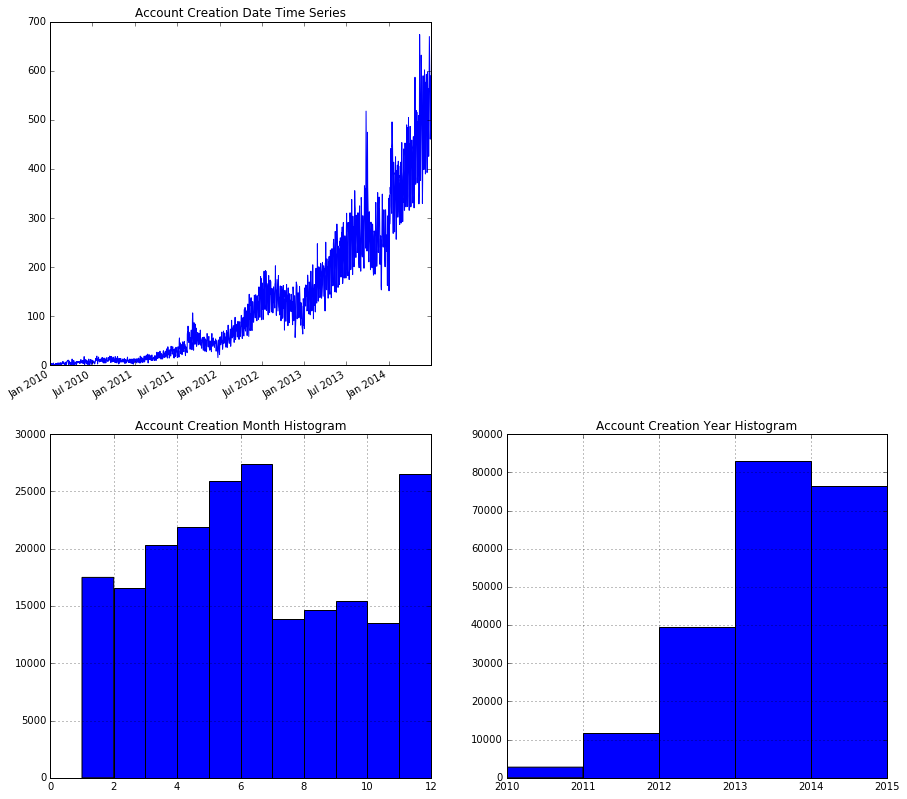

In [163]:
# Plot account created time series data.
plt.figure(figsize=(15, 15))
account_created_data = pd.to_datetime(train_data.date_account_created).value_counts()
plt.subplot(2, 2, 1)
account_created_data.plot()
plt.title("Account Creation Date Time Series")

# Plot account created month data.
account_created_month = pd.to_datetime(train_data.date_account_created).dt.month
plt.subplot(2, 2, 3)
account_created_month.hist(bins=range(1,13))
plt.title("Account Creation Month Histogram")

# Plot account created year data.
account_created_year = pd.to_datetime(train_data.date_account_created).dt.year
ax = plt.subplot(2, 2, 4)
account_created_year.hist(bins=[2010,2011,2012,2013,2014,2015])
ax.ticklabel_format(useOffset=False)
plt.title("Account Creation Year Histogram")

### Preparing Data

In [164]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add cleaned version of age data to features.
    age_data = CleanAgeData(data)
    # Add age data to training data.
    features_data = np.column_stack((features_data, np.array(age_data)))
    
    # Add account creation data (month and year).
    # These are currently commented out because they actually make the model performance worse.
    # Leaving them in since they might be useful for predicting NDF or booking.
#     account_creation_month = pd.to_datetime(data.date_account_created).dt.month
#     features_data = np.column_stack((features_data, np.array(account_creation_month)))
#     account_created_year = pd.to_datetime(data.date_account_created).dt.year
#     features_data = np.column_stack((features_data, np.array(account_created_year)))
    
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(train_data)
test_data_x = ExtractFeatures(test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


In [165]:
# Split train data into training and dev sets.
train_data_size = (len(train_data_x))/5*4
train_x, train_y = train_data_x[:train_data_size], train_data_y[:train_data_size]
dev_x, dev_y= train_data_x[train_data_size:], train_data_y[train_data_size:]

# save dev id to be used in score calculation
dev_id = np.array(train_data["id"][train_data_size:])
dev_dict = dict(zip(dev_id, dev_y))

print train_x.shape, train_y.shape
print dev_x.shape, dev_y.shape, dev_id.shape

#******************************************
# Try SMOTE here
#******************************************
print "\nTraining data after SMOTE"

country = 'FR'
train_x_c = train_x[train_y == country]

#SMOTE(minority data, new data size, NN steps)
#To double minority data example size, set N=1
#NN default = 5 neighbours
N = 4
train_x_c2 =  SMOTE(train_x_c,N*100,5)

#Append new data to train_x
train_x = np.vstack((train_x, train_x_c2))
#Append label to train_y
new_label = []
for i in range(N * len(train_x_c)):
    new_label.append(country)
train_y = np.concatenate((train_y, np.array(new_label)))

print train_x.shape, train_y.shape

#****** End of SMOTE test block **************

(170760, 6) (170760,)
(42691, 6) (42691,) (42691,)

Training data after SMOTE
(187460, 6) (187460,)


In [166]:
# Calculate DCG score based on Kaggle evaluation doc
def FinalScore(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            #scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    #scores.append((cur_id, dcg))
    
    return score/num_pred
    #return scores

In [167]:
# Build on top of DCG score function, output more prediction data
def Dump(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    scores.append((cur_id, dcg))
    
    #Output more info for error analysis
    dev_scores = dict(scores)
    dump = []
    temp_list = []
    for i in range(len(dev_x)):        
        temp_list = [dev_id[i], dev_y[i], dev_scores[dev_id[i]]]        
        dump.append(dev_x[i].tolist() + temp_list) 

    output = pd.DataFrame(dump, columns=["gender", "signup_method", "language", "first_device_type", 
                                         "first_browser", "age", "id", "country","score"])
    output.to_csv("dev_x_score.csv", index=False)
    
    buckets = [1.0, 0.6309, 0.5, 0.4307, 0.3869, 0.0]    
    plt.figure(figsize=(15, 15))
    
    for i in range(len(buckets)):    
        pred_count = output[abs(output.score - buckets[i]) < 0.001].country.value_counts()
        plt.subplot(2, 3, i+1)
        pred_count.plot.bar()

        if(i<5):
            plt.title("Correct prediction on attempt " + str(i+1))
            print "\nCorrect prediction dist on attempt %d"%(i+1)
        else:
            plt.title("Incorrect prediction dist")
            print "\nIncorrect prediction dist"
            
        print pred_count
    
    print "\nScore: %7.5f"%(score/num_pred)
    
    return 

In [168]:
# Helper function to return top 5 prediction result per example
# given a trained model.
def Predict_Top5(m):
    prob_est = m.predict_proba(dev_x)
    predictions = []
    
    for i, example in enumerate(prob_est):
        sorted_scores = np.sort(example)
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = example.tolist().index(score)
            predictions.append((dev_id[i], m.classes_[index_of_score]))
    
    return predictions

In [169]:
# Output countries that were predicted with the highest probability (first)
# while the correct country was predcited with lower probability (second)
def WhichIsFirst(predictions, country):
    
    # turn on to print debugging detail
    to_print = False

    # init variables
    k, first, label = 0, '', ''
    tally = {}
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        
        #start a new group, reset trackers       
        if p[0] != cur_id:
            k, cur_id= 0, p[0]

        k += 1         
        label = dev_dict[cur_id]
        if to_print: print "%d) %s %s.....label=%s"%(k, p[0], p[1], label)
        
        # record the country with highest probability (first)
        if k==1:                 
            first = p[1]
        
        # update dict if 2nd prediction is the correct prediction and the country inquired
        if k==2 and p[1] != first and p[1] == country and label == country :
            
            #add new keys in dict
            if first not in tally:
                if to_print: print "..........add %s to dict"%(first)
                tally[first] = 0
            # increase tally
            tally[first] += 1
            
    #output countries predicted first in decending order
    for i, d in enumerate( sorted(tally.items(), key=lambda x: x[1], reverse=True)):
        print "%6s %5d"%(d[0], d[1])

The following SMOTE function was copied from this source:
    http://comments.gmane.org/gmane.comp.python.scikit-learn/5278

In [170]:
def SMOTE(T, N, k):
    """
    Returns (N/100) * n_minority_samples synthetic minority samples.

    Parameters
    ----------
    T : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 

    Returns
    -------
    S : array, shape = [(N/100) * n_minority_samples, n_features]
    """    
    n_minority_samples, n_features = T.shape
    
    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")
    
    N = N/100
    n_synthetic_samples = N * n_minority_samples
    S = np.zeros(shape=(n_synthetic_samples, n_features))
    
    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    
    #Calculate synthetic samples
    for i in xrange(n_minority_samples):
        nn = neigh.kneighbors(T[i], return_distance=False)
        for n in xrange(N):
            nn_index = random.choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it 
            while nn_index == i:
                nn_index = random.choice(nn[0])
                
            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    
    return S


### Multinomial Naive Bayes

Commented out for now....

In [171]:
# Train Naive Bayes Model.
#mnb = MultinomialNB()
#mnb.fit(train_x, train_y)
#print "Classes: {0}".format(mnb.classes_)
#print "Class count: {0}".format(mnb.class_count_)
#print "Accuracy: {0}".format(mnb.score(dev_x, dev_y))
#predictions = mnb.predict(dev_x)
#print "F1 score: {0}".format(metrics.f1_score(dev_y,predictions,average="weighted"))

In [172]:
# Predict test data using multinomial model.
#test_predictions = mnb.predict(test_data_x)
#output = pd.concat([test_data["id"], pd.DataFrame(test_predictions, columns=["country"])], axis=1)
# Update version everytime!
#version = 1
#output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1304 with score of 0.63168.

In [173]:
# Predict Top 5 cities for each test example using multinomial model.
#prob_est = mnb.predict_proba(test_data_x)
#predictions = []
#for i, example in enumerate(prob_est):
#    sorted_scores = np.sort(example)
#    top_5 = sorted_scores[len(sorted_scores) - 5:]
#    for score in reversed(top_5):
#        index_of_score = example.tolist().index(score)
#        predictions.append((test_data["id"][i], mnb.classes_[index_of_score]))
#output2 = pd.DataFrame(predictions, columns=["id", "country"])
#version = 2
#output2.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1142 with score of 0.79584.

### Logistic Regression

In [174]:
# Train Logistic Regression Model.
lr = LogisticRegression(penalty='l2')
lr.fit(train_x, train_y)
lr_predictions = lr.predict(dev_x)
#print "F1 score: {0}".format(metrics.f1_score(dev_y,lr_predictions,average="weighted"))

In [175]:
# Predict Top 5 cities for each test example using logistic regression model.
prob_est = lr.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], lr.classes_[index_of_score]))
output3 = pd.DataFrame(predictions, columns=["id", "country"])
version = 6
output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1049 with score of 0.85894.


Correct prediction dist on attempt 1
NDF    23781
US      3083
Name: country, dtype: int64

Correct prediction dist on attempt 2
US     8260
NDF    2244
FR       31
Name: country, dtype: int64

Correct prediction dist on attempt 3
FR       814
NDF      322
other     25
Name: country, dtype: int64

Correct prediction dist on attempt 4
other    1966
NDF         4
FR          3
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT    494
ES     57
GB     21
Name: country, dtype: int64

Incorrect prediction dist
GB    414
ES    361
CA    300
NL    160
DE    150
AU     77
IT     70
PT     54
Name: country, dtype: int64

Score: 0.82365


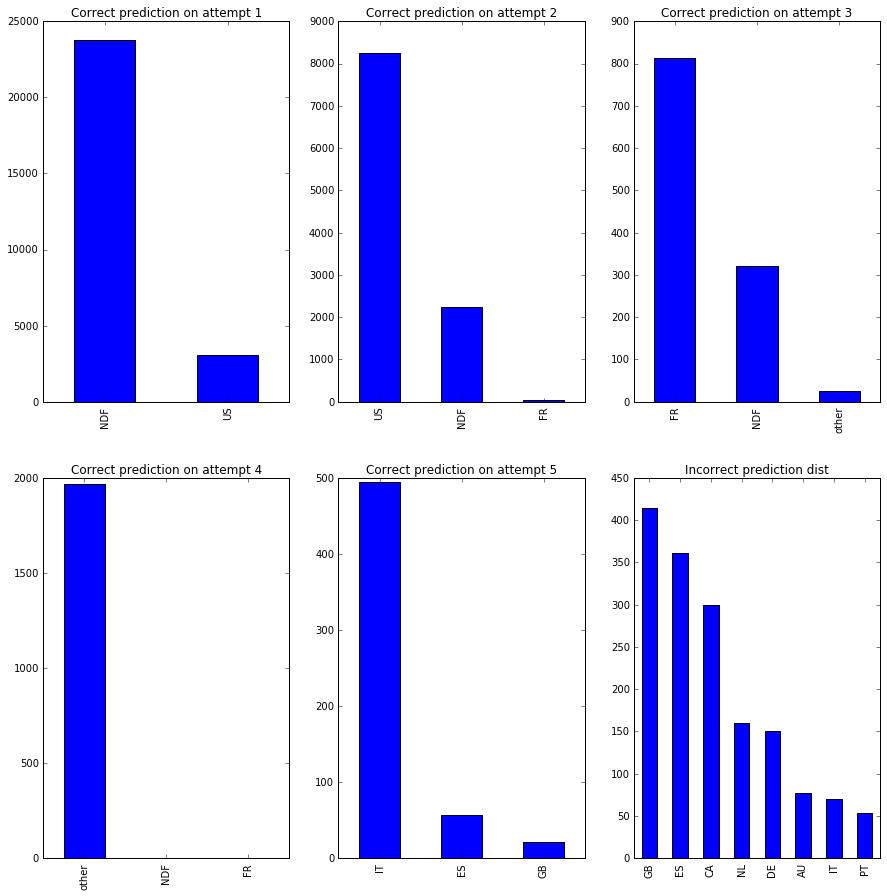

In [176]:
Dump(Predict_Top5(lr))

### Random Forest

In [177]:
# Train Random forest.
rf= RandomForestClassifier(n_estimators=10)
rf.fit(train_x, train_y)
rf_predictions = rf.predict(dev_x)
print "F1 score: {0}".format(metrics.f1_score(dev_y,rf_predictions,average="weighted"))

F1 score: 0.601725436708


In [178]:
# Predict Top 5 cities for each test example using Random forest model.
prob_est = rf.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], rf.classes_[index_of_score]))
output4 = pd.DataFrame(predictions, columns=["id", "country"])
version = 4
output4.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1137 with score of 0.82136.


final score: 0.81583

Correct prediction dist on attempt 1
NDF      22126
US        5213
FR          12
other       11
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       5620
NDF      3387
FR         51
other      46
IT          5
CA          3
DE          1
NL          1
ES          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
NDF      662
other    524
FR       416
US       259
IT        11
GB        11
CA         4
ES         2
AU         2
DE         1
NL         1
Name: country, dtype: int64

Correct prediction dist on attempt 4
other    995
FR        76
NDF       50
IT        45
ES        26
GB        26
US        23
CA         5
DE         3
PT         1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       176
GB        76
other     68
ES        54
FR        46
CA        15
AU         9
NDF        8
US         4
DE         4
NL         2
Name: country, dtype: int64

Incorrect prediction dist
other    347
ES    

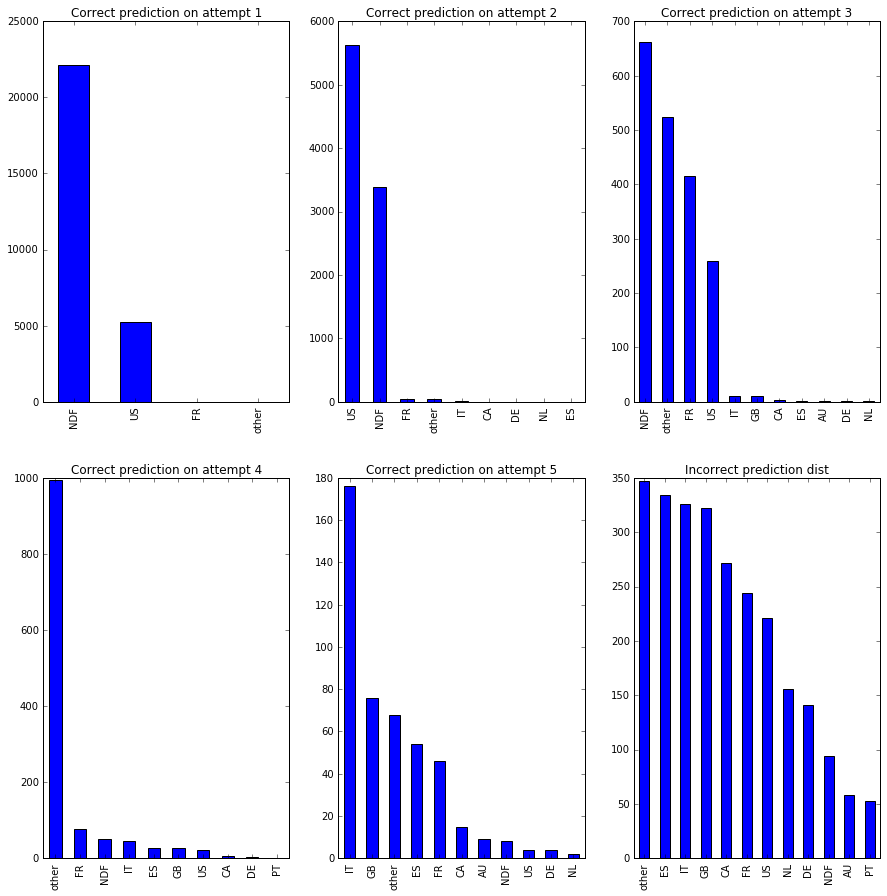

In [179]:
print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(rf)))
Dump(Predict_Top5(rf))

In [180]:
# Try voting ensemble
vc = VotingClassifier(estimators=[ ('lr', lr), ('rf', rf)], voting='soft')
vc.fit(train_x, train_y)

# Predict Top 5 cities for each test example using Random forest model.
prob_est = vc.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], vc.classes_[index_of_score]))
output = pd.DataFrame(predictions, columns=["id", "country"])
version = 7
output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1032 with score of 0.86252.

print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(vc)))


final score: 0.83040



Correct prediction dist on attempt 1
NDF      22592
US        5114
other        3
FR           2
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       6132
NDF      3588
FR         11
other       9
ES          1
IT          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
FR       704
other    303
NDF      156
US        95
IT         4
CA         2
DE         1
Name: country, dtype: int64

Correct prediction dist on attempt 4
other    1527
FR        122
NDF        15
IT         14
GB         12
ES          5
US          2
CA          2
AU          1
NL          1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       294
other    127
GB        83
ES        60
CA        10
FR         9
DE         3
NL         2
PT         1
Name: country, dtype: int64

Incorrect prediction dist
ES       352
GB       340
CA       286
IT       251
NL       157
DE       146
AU        76
PT        53
other     22
Name: country, dtype: int64

Score

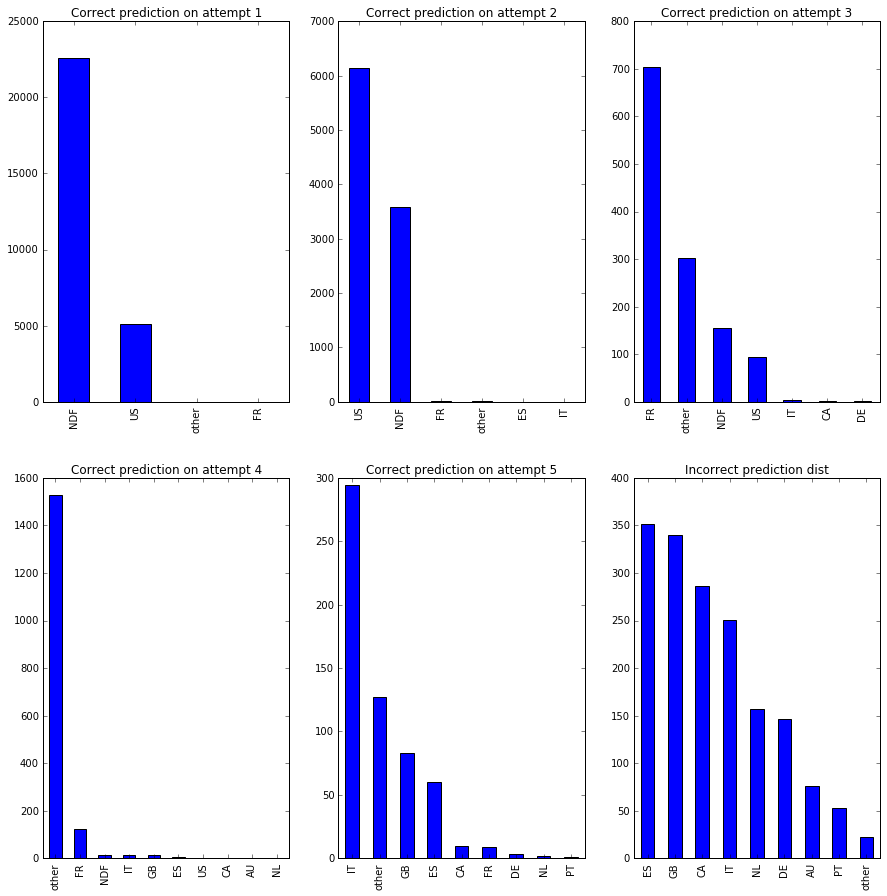

In [181]:
Dump(Predict_Top5(vc))

### Log of Improvements
1. Multinomial NB  
Baseline score: 0.63168  
Baseline rank: 1304  
2. Multinomial NB with Top 5 predictions  
Score: 0.79584  
Rank: 1142
3. Logistic Regression with Top 5 predictions  
Score: 0.85894  
Rank: 1049
4. Random Forest with Top 5 predictions  
Score: 0.81781  
Rank: 1138  
5. Logistic Regression with Age data clean-up  
Score improvement: 0.85970  
Rank improvement: 1044  
6. Soft voting with Logistic Regression and Random Forest   
Score improvement: 0.86252  
Rank improvement: 1032  


# Error Analysis

In [182]:
import operator
def error_analysis(model, dev_x, dev_y):
    """
    Due to the large frequence of NDFs, the matrix needs to be normalized if we're to see anything helpful in this viz.
    """
    preds = model.predict(dev_x) ##Compute predictions given model
    labels = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']    
    ###Accuracy Statistics###
    print 'FinalScore metric value: ', FinalScore(Predict_Top5(model))
    print "precision answers: where we measure 'country', what fraction actually was 'country'?"
    print "recall answers: of all that were 'country', what fraction did we correctly predict 'country'?"
    print "goal is to have both high precision and recall scores"
    print 'Precision and Recall scores: \n'
    precision = []
    recall = []
    for country in labels:
        binarized_devy = dev_y == country
        binarized_preds = preds == country
        precision.append(metrics.precision_score(binarized_devy, binarized_preds))
        recall.append(metrics.recall_score(binarized_devy, binarized_preds))
    p_r_dict = {'precision':precision, 'recall':recall}
    p_r_df = pd.DataFrame(p_r_dict, index=labels)
    print p_r_df
    ###Confusion Matrix###
    c_matx = metrics.confusion_matrix(dev_y, preds)
    c_matx_n = c_matx.astype('float') / c_matx.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(c_matx_n, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ###Error count###
    sums = {}
    series = {}
    for i in range(len(c_matx)):
        sums[labels[i]] = 0
        labs = []
        data = []
        for j in range(len(c_matx[i])):
            if i != j:
                sums[labels[i]] += c_matx[i][j]
                labs.append(labels[j])
                data.append(c_matx[i][j])
        series[labels[i]] = pd.Series(data, index=labs)
        series[labels[i]].sort_values(inplace=True, ascending=False)
    sorted_sums = sorted(sums.items(), key=operator.itemgetter(1), reverse=True)
    error_counts = pd.Series([x[1] for x in sorted_sums], [x[0] for x in sorted_sums])
    print 'Error Counts: \n\n', error_counts
    ###Top 5 Error Histograms###
    plt.figure(figsize=(15, 30))
    plt_indx = 1
    for country in [x[0] for x in sorted_sums[0:5]]:
        plt.subplot(5,1,plt_indx)
        series[country].plot.bar()
        plt.title("For '" + country + "' the model incorrectly guessed...")
        plt_indx += 1

FinalScore metric value:  0.83039644862
precision answers: where we measure 'country', what fraction actually was 'country'?
recall answers: of all that were 'country', what fraction did we correctly predict 'country'?
goal is to have both high precision and recall scores
Precision and Recall scores: 

       precision    recall
AU      0.000000  0.000000
CA      0.000000  0.000000
DE      0.000000  0.000000
ES      0.000000  0.000000
FR      0.029851  0.002358
GB      0.000000  0.000000
IT      0.000000  0.000000
NDF     0.712951  0.857349
NL      0.000000  0.000000
PT      0.000000  0.000000
US      0.470296  0.450851
other   0.081081  0.001507
Error Counts: 

US       6229
NDF      3759
other    1988
FR        846
IT        564
GB        435
ES        418
CA        300
NL        160
DE        150
AU         77
PT         54
dtype: int64


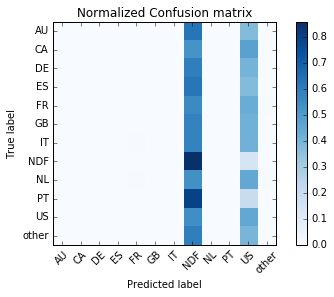

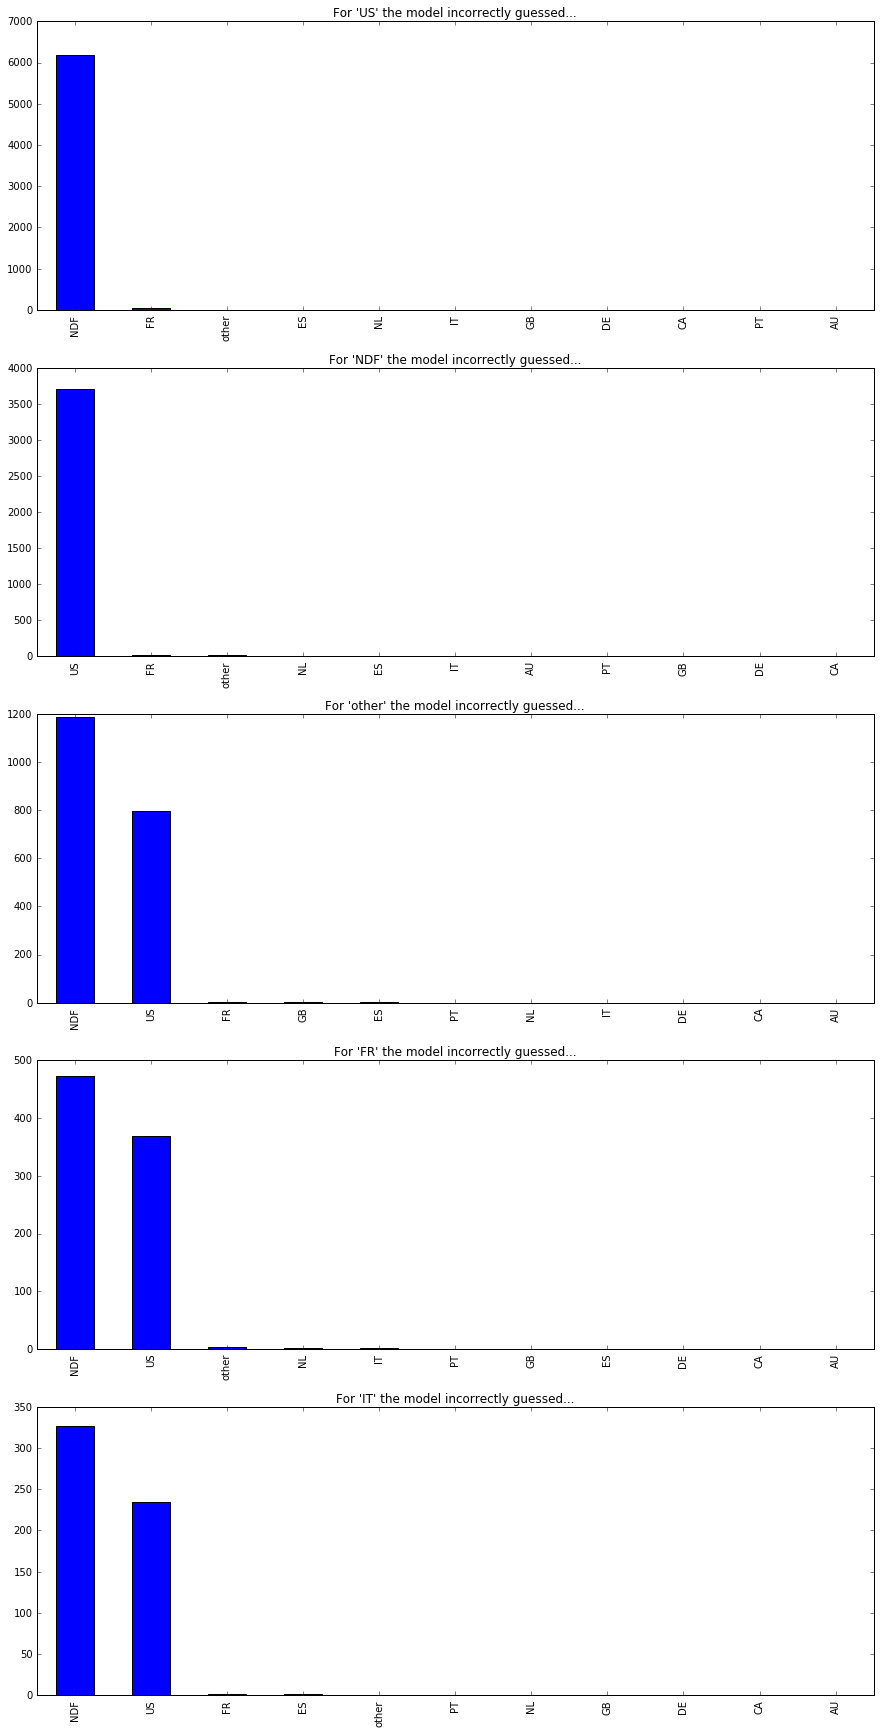

In [183]:
error_analysis(vc, dev_x, dev_y)